In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

Reading Data

In [2]:
file_path = r'C:\python\Copper_Set.xlsx'
df = pd.read_excel(file_path)
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [4]:
df.describe()

,item_date,customer,country,application,thickness,width,product_ref,delivery date,selling_price
count,1.816720e+05,1.816720e+05,181645.000000,181649.000000,181672.000000,181673.000000,1.816730e+05,1.816720e+05,1.816720e+05
mean,2.020459e+07,3.051221e+07,44.893022,25.615809,2.564827,1295.286724,4.739679e+08,2.020738e+07,1.918036e+03
std,4.551119e+03,2.433382e+07,24.404214,17.754175,6.572321,261.631754,7.175101e+08,2.411059e+04,3.317956e+05
min,1.995000e+07,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,2.019040e+07,-1.160000e+03
25%,2.020093e+07,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2.020110e+07,6.690000e+02
50%,2.020113e+07,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2.021010e+07,8.120000e+02
75%,2.021020e+07,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2.021040e+07,9.530000e+02
max,2.021040e+07,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,3.031010e+07,1.000010e+08


Identifying unique values

In [5]:
for column in df.columns:
    print(f"{column}: {df[column].nunique()}")

id: 181671
item_date: 252
quantity tons: 181673
customer: 1169
country: 17
status: 9
item type: 7
application: 30
thickness: 594
width: 1386
material_ref: 16563
product_ref: 33
delivery date: 28
selling_price: 9795


In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print("Total missing values by column:")
print(missing_values)

Total missing values by column:
id                   2
item_date            1
quantity tons        0
customer             1
country             28
status               2
item type            0
application         24
thickness            1
width                0
material_ref     77919
product_ref          0
delivery date        1
selling_price        1
dtype: int64


Replacing the values

In [7]:
# Replace rubbish values in ‘material_ref’ that start with ‘00000’ with NaN
df['material_ref'] = df['material_ref'].apply(lambda x: np.nan if str(x).startswith('00000') else x)

# Convert 'quantity tons' to numeric and replace negative or zero values with NaN
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
df['quantity tons'] = df['quantity tons'].apply(lambda x: np.nan if x <= 0 else x)

# Replace negative or zero values in 'selling_price' with NaN
df['selling_price'] = df['selling_price'].apply(lambda x: np.nan if x <= 0 else x)

changing data types

In [8]:
df["item_date_1"] = pd.to_datetime(df["item_date"], format="%Y%m%d", errors="coerce")
df["delivery date_1"] = pd.to_datetime(df["delivery date"], format="%Y%m%d", errors="coerce")

# Define continuous features
continuous_features = ['quantity tons', 'thickness', 'width', 'selling_price', 'delivery date_1','item_date_1']


df.dtypes

id                         object
item_date                 float64
quantity tons             float64
customer                  float64
country                   float64
status                     object
item type                  object
application               float64
thickness                 float64
width                     float64
material_ref               object
product_ref                 int64
delivery date             float64
selling_price             float64
item_date_1        datetime64[ns]
delivery date_1    datetime64[ns]
dtype: object

In [9]:
# Check for missing values after conversion
missing_values = df.isnull().sum()
print("Total missing values by column after initial conversion:")
print(missing_values)

Total missing values by column after initial conversion:
id                      2
item_date               1
quantity tons           5
customer                1
country                28
status                  2
item type               0
application            24
thickness               1
width                   0
material_ref       100645
product_ref             0
delivery date           1
selling_price           8
item_date_1             3
delivery date_1         3
dtype: int64


In [10]:
#dropping material_ref columns
df.drop(columns=["id","material_ref"],inplace=True)

Handling missing values

In [11]:
# Continuous variables
df['quantity tons'] = df['quantity tons'].fillna(df['quantity tons'].mean())
df['thickness'] = df['thickness'].fillna(df['thickness'].median())
df['selling_price'] = df['selling_price'].fillna(df['selling_price'].mean())
# Categorical variables
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['customer'] = df['customer'].fillna(df['customer'].mode()[0])
df['application'] = df['application'].fillna(df['application'].mode()[0])
df['status'] = df['status'].fillna(df['status'].mode()[0])

In [12]:
missing_values = df.isnull().sum()
print("Total missing values by column:")
print(missing_values)

Total missing values by column:
item_date          1
quantity tons      0
customer           0
country            0
status             0
item type          0
application        0
thickness          0
width              0
product_ref        0
delivery date      1
selling_price      0
item_date_1        3
delivery date_1    3
dtype: int64


In [13]:
df.dropna(inplace=True)

In [14]:
# Check for missing values after dropping NaN rows
missing_values = df.isnull().sum()
print("Total missing values by column after dropping NaN rows:")
print(missing_values)

Total missing values by column after dropping NaN rows:
item_date          0
quantity tons      0
customer           0
country            0
status             0
item type          0
application        0
thickness          0
width              0
product_ref        0
delivery date      0
selling_price      0
item_date_1        0
delivery date_1    0
dtype: int64


In [15]:
df.describe()

,item_date,quantity tons,customer,country,application,thickness,width,product_ref,delivery date,selling_price,item_date_1,delivery date_1
count,1.816670e+05,1.816670e+05,1.816670e+05,181667.000000,181667.000000,181667.000000,181667.000000,1.816670e+05,1.816670e+05,1.816670e+05,181667,181667
mean,2.020459e+07,5.875258e+03,3.051222e+07,44.898149,25.613788,2.564867,1295.285308,4.739735e+08,2.020733e+07,1.918157e+03,2020-11-26 22:56:12.883352832,2021-01-25 22:43:35.259788544
min,2.020070e+07,1.000000e-05,1.245800e+04,25.000000,2.000000,0.180000,1.000000,6.117280e+05,2.019040e+07,1.000000e-01,2020-07-02 00:00:00,2019-04-01 00:00:00
25%,2.020093e+07,1.097105e+01,3.019688e+07,26.000000,10.000000,0.700000,1180.000000,6.119930e+05,2.020110e+07,6.690000e+02,2020-09-29 00:00:00,2020-11-01 00:00:00
50%,2.020113e+07,3.036536e+01,3.020524e+07,30.000000,15.000000,1.500000,1250.000000,6.406650e+05,2.021010e+07,8.120000e+02,2020-11-30 00:00:00,2021-01-01 00:00:00
75%,2.021020e+07,6.716757e+01,3.028042e+07,78.000000,41.000000,3.000000,1500.000000,1.332077e+09,2.021040e+07,9.530000e+02,2021-02-03 00:00:00,2021-04-01 00:00:00
max,2.021040e+07,1.000000e+09,2.147484e+09,113.000000,99.000000,2500.000000,2990.000000,1.722208e+09,2.022010e+07,1.000010e+08,2021-04-01 00:00:00,2022-01-01 00:00:00
std,4.511681e+03,2.349114e+06,2.433415e+07,24.405797,17.753670,6.572405,261.635410,7.175126e+08,4.416530e+03,3.318002e+05,NaN,NaN


In [16]:
df.describe(include='object')

,status,item type
count,181667,181667
unique,9,7
top,Won,W
freq,116009,105614


In [17]:
df.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price,item_date_1,delivery date_1
0,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,1670798778,20210701.0,854.00,2021-04-01,2021-07-01
1,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,1668701718,20210401.0,1047.00,2021-04-01,2021-04-01
2,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,628377,20210101.0,644.33,2021-04-01,2021-01-01
3,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,1668701718,20210101.0,768.00,2021-04-01,2021-01-01
4,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,640665,20210301.0,577.00,2021-04-01,2021-03-01


In [18]:
df['status'].unique()

array(['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM',
       'Wonderful', 'Revised', 'Offered', 'Offerable'], dtype=object)

In [19]:
df['item type'].unique()

array(['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR'], dtype=object)

In [20]:
df["status"]= df["status"].map({'Won':1, 'Draft':2, 'To be approved':3, 'Lost':0, 'Not lost for AM':4,
                                'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8})

In [21]:
df["item type"]= OrdinalEncoder().fit_transform(df[["item type"]])

In [22]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,181667.0,20204589.70436,20200702.0,20200929.0,20201130.0,20210203.0,20210401.0,4511.681316
quantity tons,181667.0,5875.258492,0.00001,10.971048,30.365363,67.16757,1000000000.0,2349113.567944
customer,181667.0,30512215.324963,12458.0,30196884.0,30205242.0,30280416.0,2147483647.0,24334150.420567
country,181667.0,44.898149,25.0,26.0,30.0,78.0,113.0,24.405797
status,181667.0,1.316695,0.0,1.0,1.0,1.0,8.0,1.330318
item type,181667.0,4.133062,0.0,3.0,5.0,5.0,6.0,1.055229
application,181667.0,25.613788,2.0,10.0,15.0,41.0,99.0,17.75367
thickness,181667.0,2.564867,0.18,0.7,1.5,3.0,2500.0,6.572405
width,181667.0,1295.285308,1.0,1180.0,1250.0,1500.0,2990.0,261.63541
product_ref,181667.0,473973462.089174,611728.0,611993.0,640665.0,1332077137.0,1722207579.0,717512632.040091


In [23]:
df.to_csv("Industrial_Copper_proper.csv",index= False)

In [24]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
skewness = df[numerical_columns].skew()
print(skewness)

item_date          0.447846
quantity tons    424.683803
customer          86.983871
country            0.753091
status             1.797408
item type         -0.487599
application        0.724532
thickness        303.443426
width              0.374606
product_ref        1.015196
delivery date     -0.742769
selling_price    301.383111
dtype: float64


In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

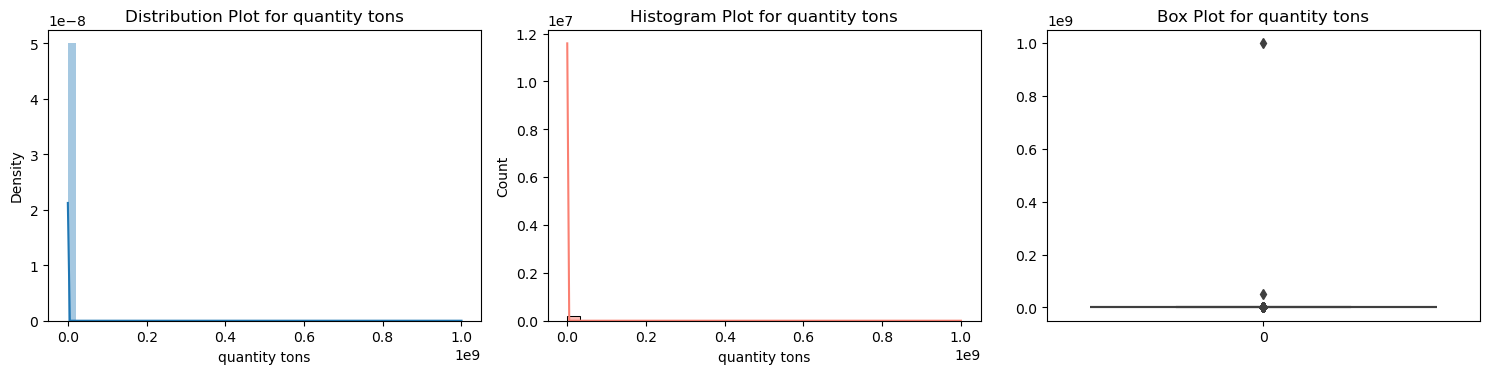

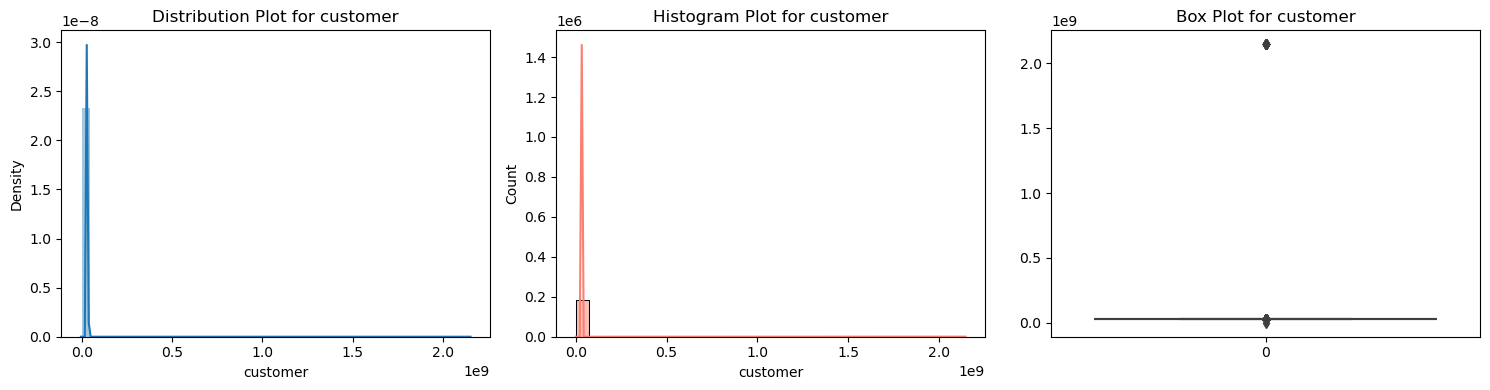

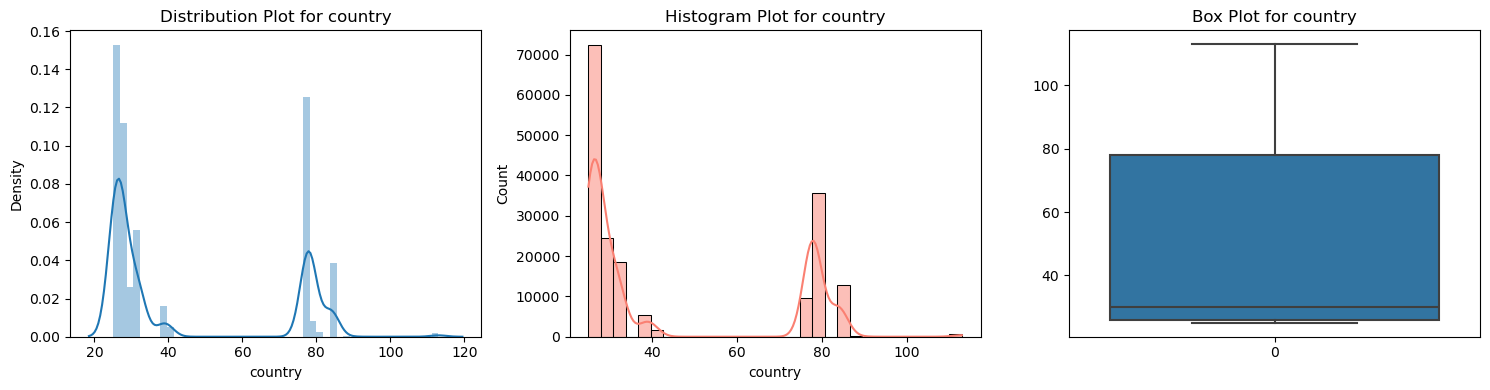

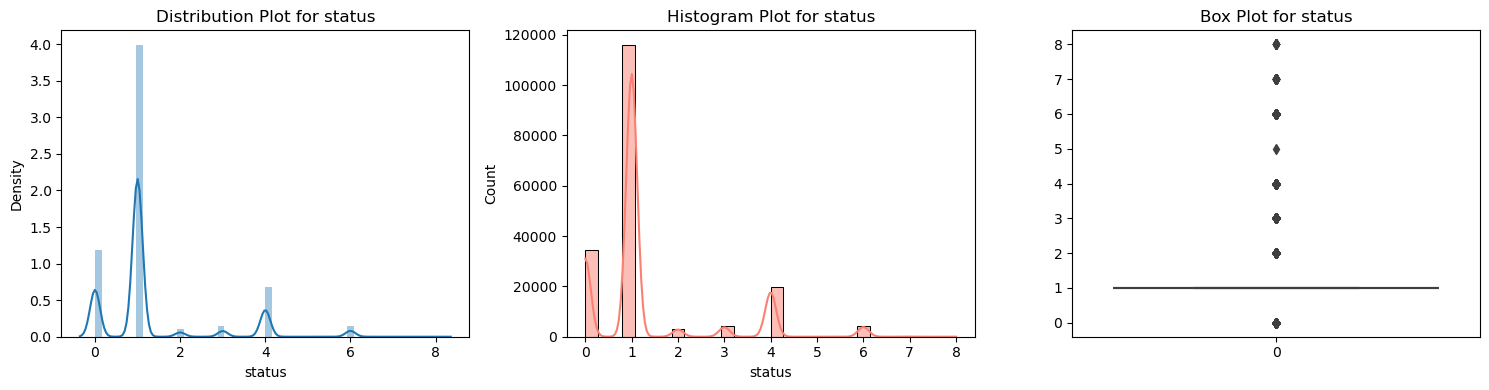

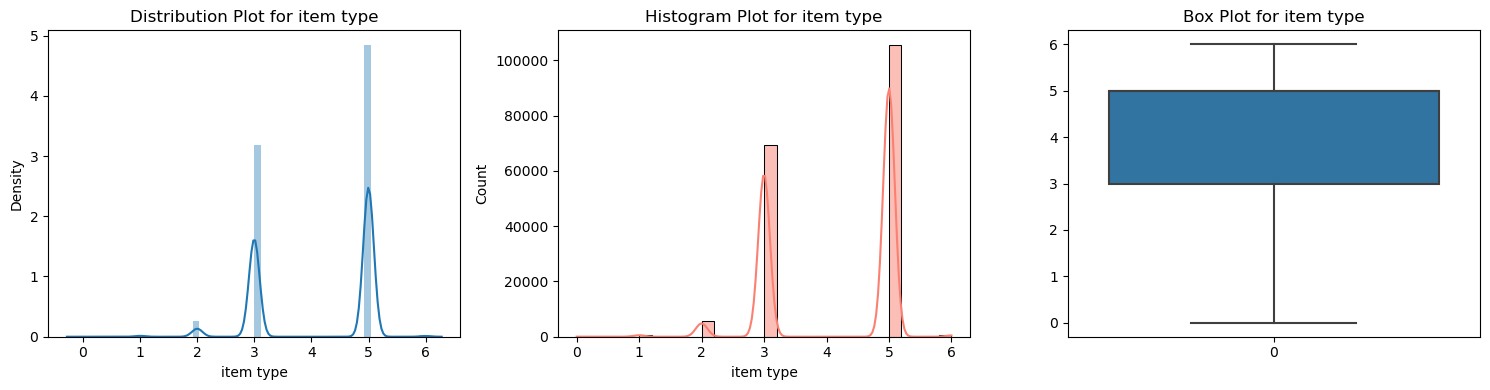

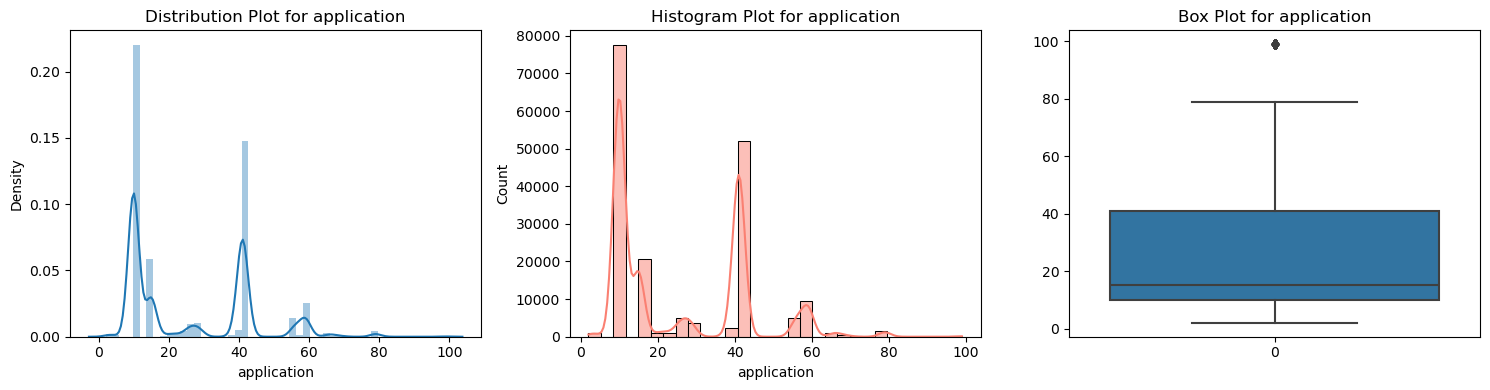

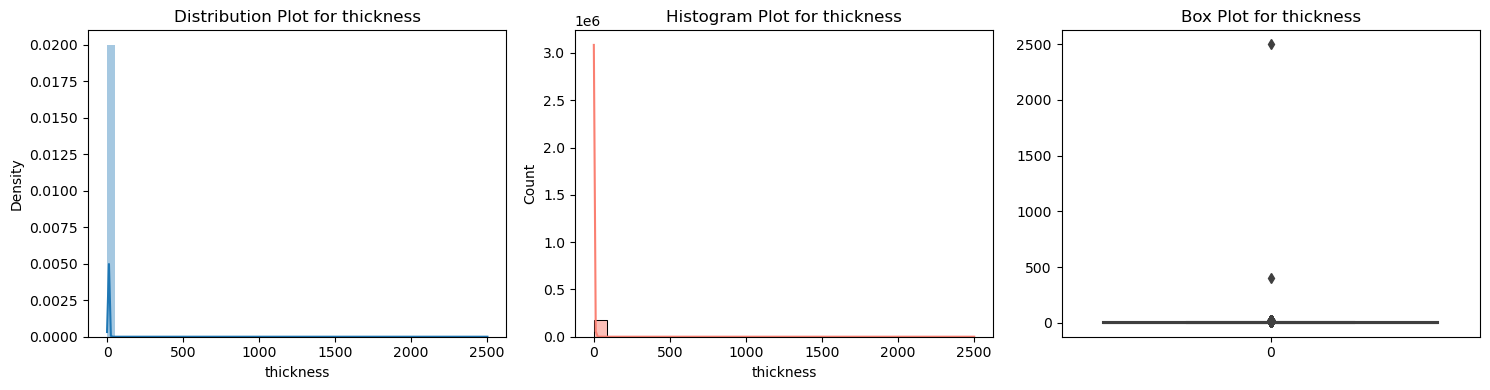

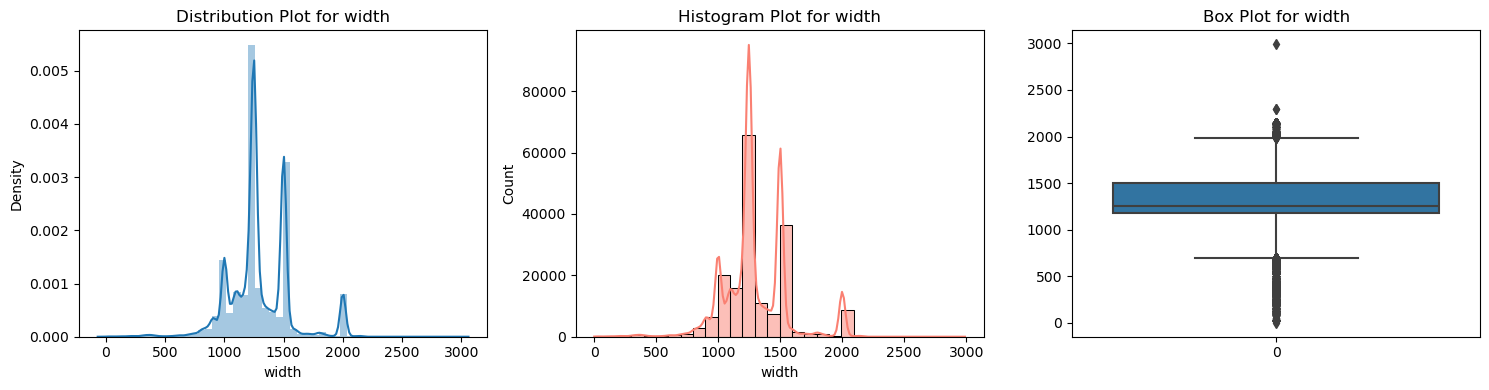

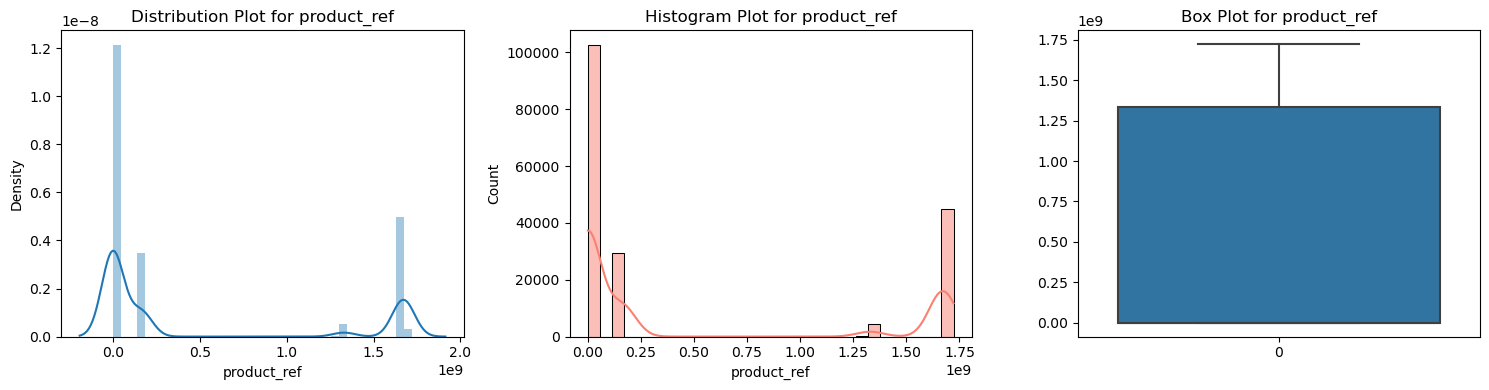

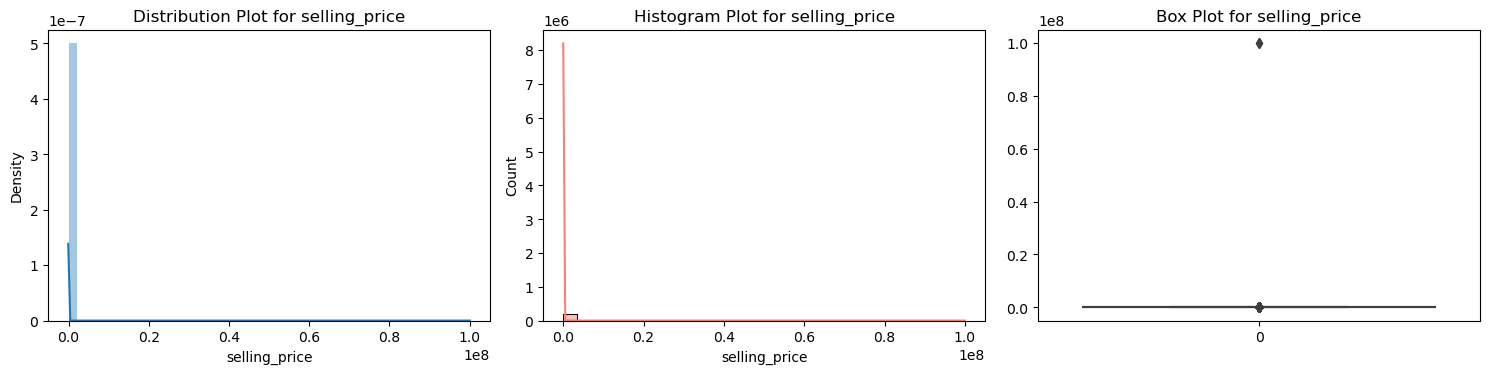

In [27]:
def plot_distribution(df, columns):
    for column in columns:
        plt.figure(figsize=(15, 4))

        # Distribution plot
        plt.subplot(1, 3, 1)
        sns.distplot(df[column])
        plt.title("Distribution Plot for " + column)

        # Histogram plot
        plt.subplot(1, 3, 2)
        sns.histplot(df[column], kde=True, bins=30, color="salmon")
        plt.title("Histogram Plot for " + column)

        # Box plot
        plt.subplot(1, 3, 3)
        sns.boxplot(df[column])
        plt.title("Box Plot for " + column)

        plt.tight_layout()
        plt.show()

# List of columns suspected to be skewed
skewed_columns = ['quantity tons', 'customer', 'country', 'status',
                  'item type', 'application', 'thickness', 'width', 'product_ref',
                  'selling_price']

# Plot skewness for each column
plot_distribution(df, skewed_columns)

In [28]:
df1 = df.copy()
df1.columns

Index(['item_date', 'quantity tons', 'customer', 'country', 'status',
       'item type', 'application', 'thickness', 'width', 'product_ref',
       'delivery date', 'selling_price', 'item_date_1', 'delivery date_1'],
      dtype='object')

In [31]:
df1["quantity_tons_log"] = np.log(df1["quantity tons"])
df1["customer_log"] = np.log(df1["customer"])
df1["thickness_log"] = np.log(df1["thickness"])
df1["selling_price_log"] = np.log(df1["selling_price"])

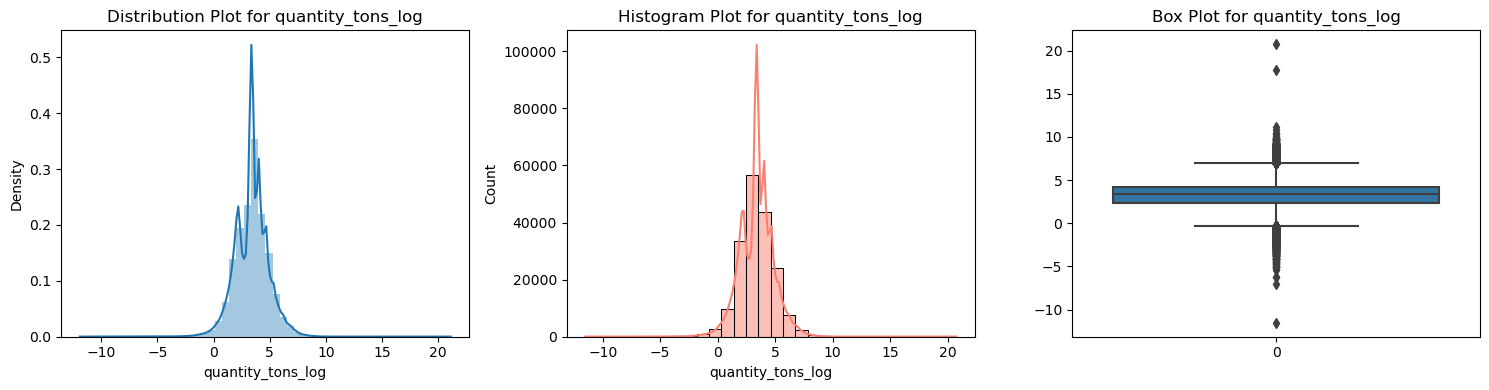

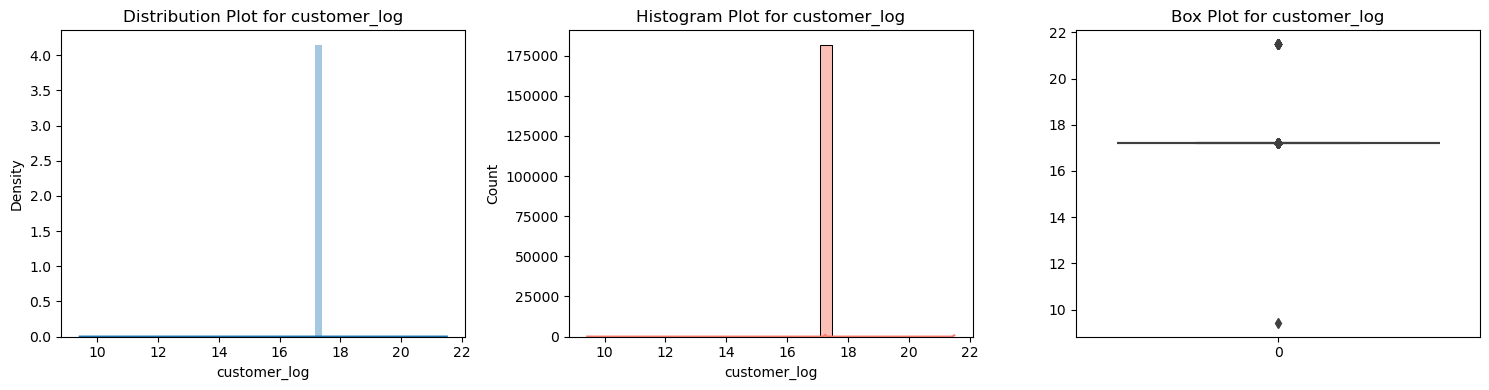

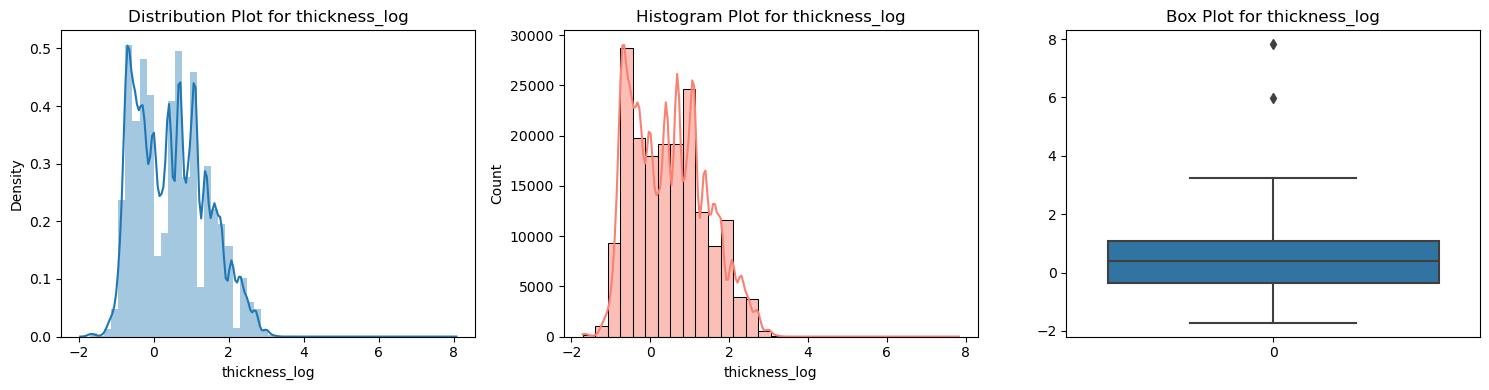

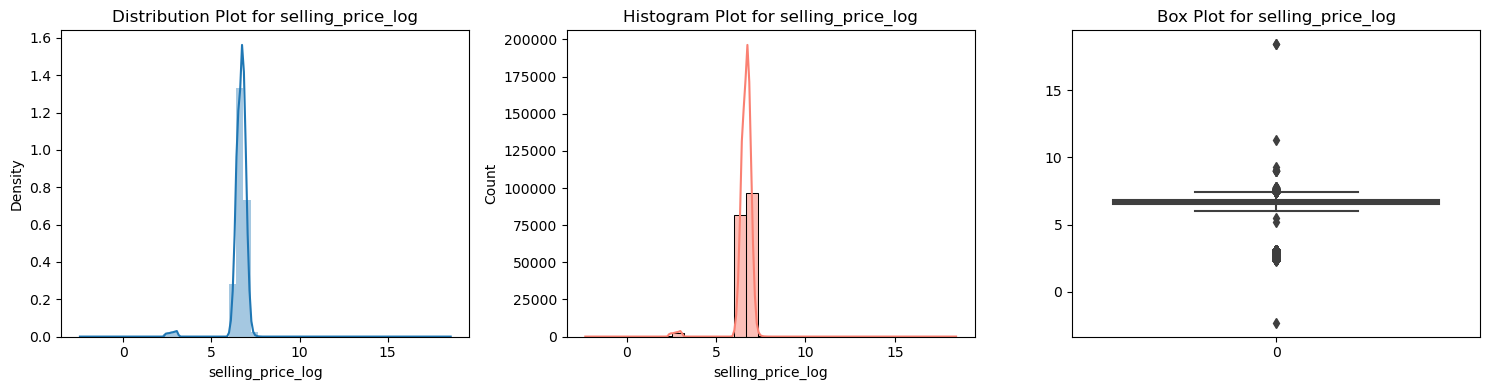

In [37]:
skewed_columns=["quantity_tons_log","customer_log","thickness_log","selling_price_log"]
plot_distribution(df1,skewed_columns)

In [38]:
df2= df1.copy()
df2.head()

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,product_ref,delivery date,selling_price,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log
0,20210401.0,54.151139,30156308.0,28.0,1,5.0,10.0,2.00,1500.0,1670798778,20210701.0,854.00,2021-04-01,2021-07-01,3.991779,17.221905,0.693147,6.749931
1,20210401.0,768.024839,30202938.0,25.0,1,5.0,41.0,0.80,1210.0,1668701718,20210401.0,1047.00,2021-04-01,2021-04-01,6.643822,17.223450,-0.223144,6.953684
2,20210401.0,386.127949,30153963.0,30.0,1,6.0,28.0,0.38,952.0,628377,20210101.0,644.33,2021-04-01,2021-01-01,5.956169,17.221827,-0.967584,6.468211
3,20210401.0,202.411065,30349574.0,32.0,1,3.0,59.0,2.30,1317.0,1668701718,20210101.0,768.00,2021-04-01,2021-01-01,5.310301,17.228293,0.832909,6.643790
4,20210401.0,785.526262,30211560.0,28.0,1,5.0,10.0,4.00,2000.0,640665,20210301.0,577.00,2021-04-01,2021-03-01,6.666354,17.223735,1.386294,6.357842


In [39]:
def outlier_treatment(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    upper_threshold = q3 + 1.5 * iqr
    lower_threshold = q1 - 1.5 * iqr
    df[column] = df[column].clip(lower_threshold, upper_threshold)

In [40]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,181667.0,20204589.70436,20200702.0,20200929.0,20201130.0,20210203.0,20210401.0,4511.681316
quantity tons,181667.0,5875.258492,0.00001,10.971048,30.365363,67.16757,1000000000.0,2349113.567944
customer,181667.0,30512215.324963,12458.0,30196884.0,30205242.0,30280416.0,2147483647.0,24334150.420567
country,181667.0,44.898149,25.0,26.0,30.0,78.0,113.0,24.405797
status,181667.0,1.316695,0.0,1.0,1.0,1.0,8.0,1.330318
item type,181667.0,4.133062,0.0,3.0,5.0,5.0,6.0,1.055229
application,181667.0,25.613788,2.0,10.0,15.0,41.0,99.0,17.75367
thickness,181667.0,2.564867,0.18,0.7,1.5,3.0,2500.0,6.572405
width,181667.0,1295.285308,1.0,1180.0,1250.0,1500.0,2990.0,261.63541
product_ref,181667.0,473973462.089174,611728.0,611993.0,640665.0,1332077137.0,1722207579.0,717512632.040091


In [41]:
df2.columns

Index(['item_date', 'quantity tons', 'customer', 'country', 'status',
       'item type', 'application', 'thickness', 'width', 'product_ref',
       'delivery date', 'selling_price', 'item_date_1', 'delivery date_1',
       'quantity_tons_log', 'customer_log', 'thickness_log',
       'selling_price_log'],
      dtype='object')

In [42]:
outlier_columns = ['quantity_tons_log', 'customer_log', 'thickness_log',
                   'selling_price_log', 'width', 'application']
for column in outlier_columns:
    outlier_treatment(df2, column)

In [43]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,181667.0,20204589.70436,20200702.0,20200929.0,20201130.0,20210203.0,20210401.0,4511.681316
quantity tons,181667.0,5875.258492,0.00001,10.971048,30.365363,67.16757,1000000000.0,2349113.567944
customer,181667.0,30512215.324963,12458.0,30196884.0,30205242.0,30280416.0,2147483647.0,24334150.420567
country,181667.0,44.898149,25.0,26.0,30.0,78.0,113.0,24.405797
status,181667.0,1.316695,0.0,1.0,1.0,1.0,8.0,1.330318
item type,181667.0,4.133062,0.0,3.0,5.0,5.0,6.0,1.055229
application,181667.0,25.604546,2.0,10.0,15.0,41.0,87.5,17.718422
thickness,181667.0,2.564867,0.18,0.7,1.5,3.0,2500.0,6.572405
width,181667.0,1297.044225,700.0,1180.0,1250.0,1500.0,1980.0,248.965355
product_ref,181667.0,473973462.089174,611728.0,611993.0,640665.0,1332077137.0,1722207579.0,717512632.040091


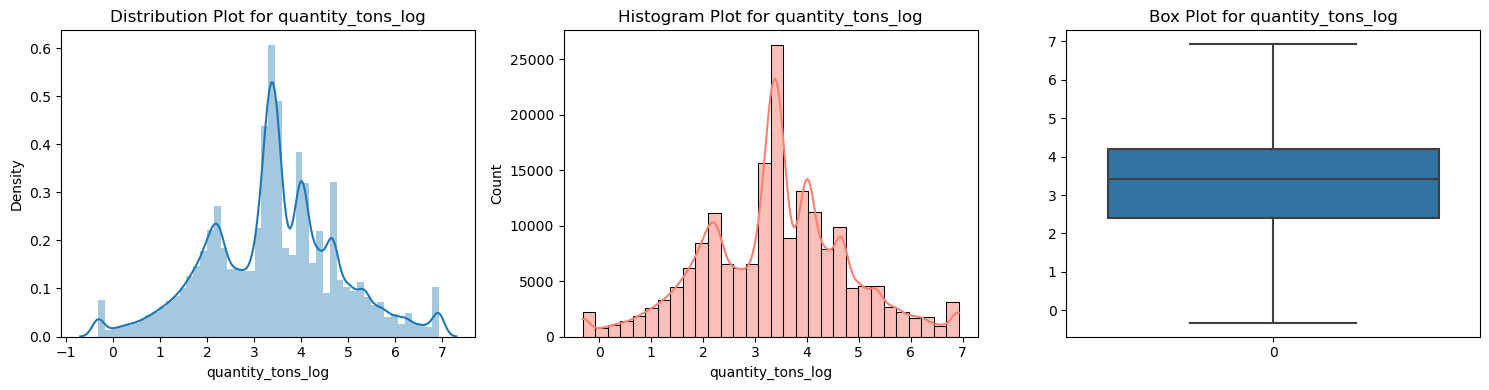

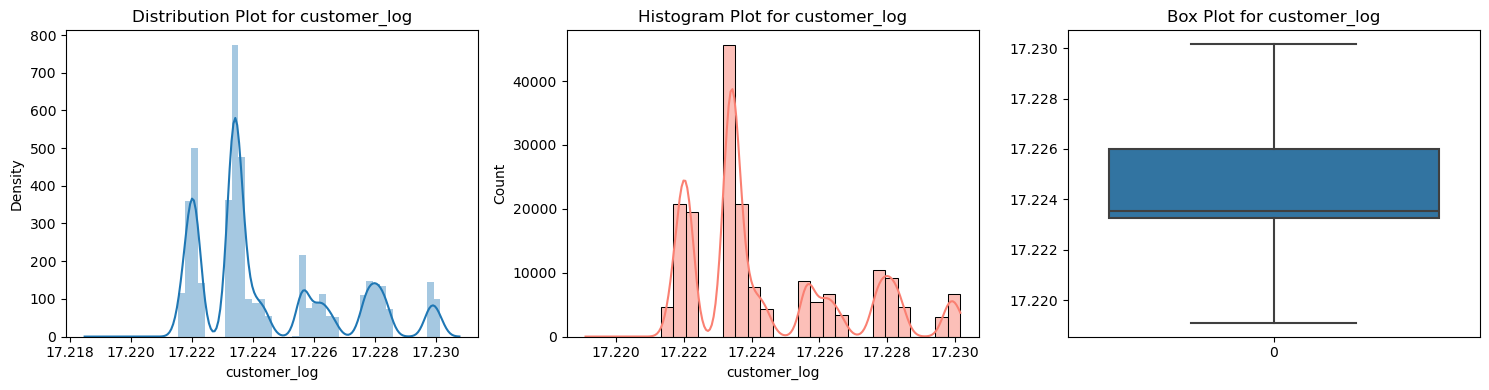

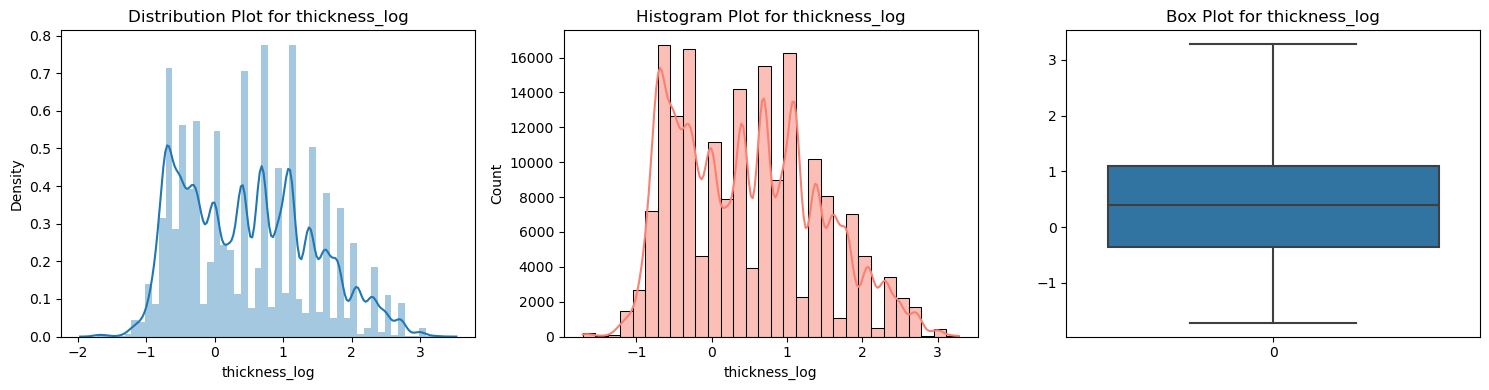

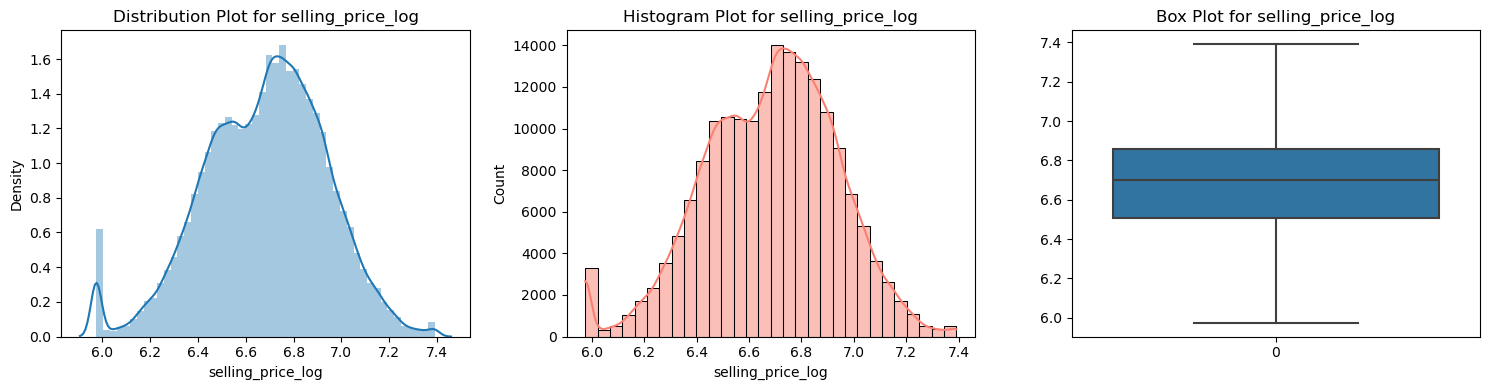

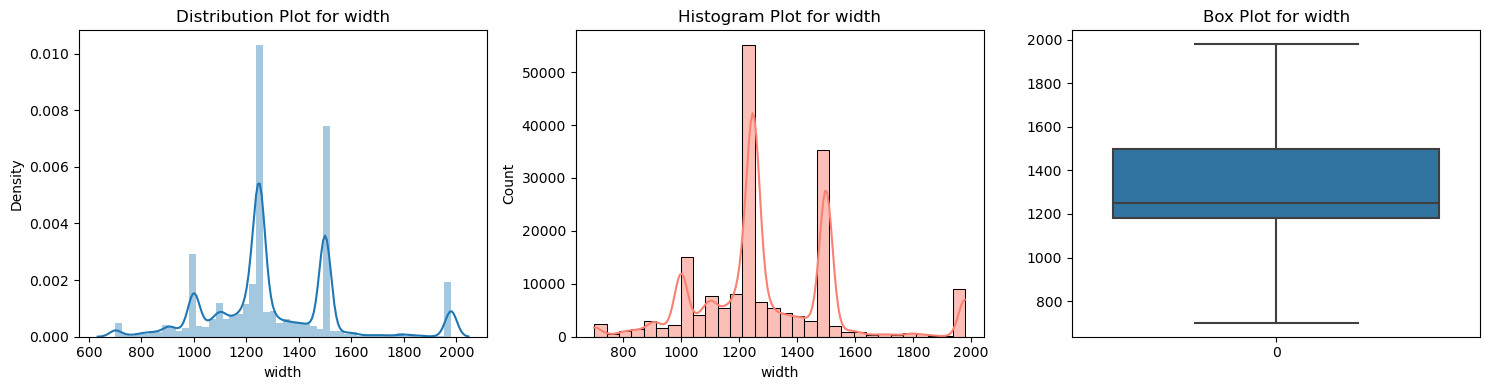

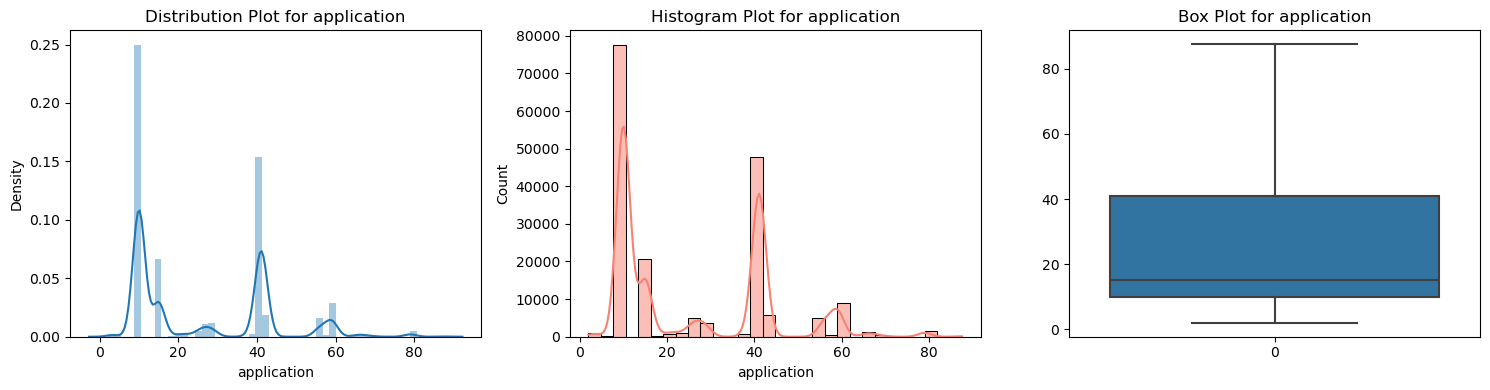

In [44]:
plot_distribution(df2,outlier_columns)

In [45]:
#Droping the unwanted skewed columns
#Skewed columns:
# 1.quantity tons
# 2.customer
# 3.thickness
# 4.selling_price

df3= df2.drop(columns=["quantity tons","customer","thickness","selling_price"])
df3.head()

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log
0,20210401.0,28.0,1,5.0,10.0,1500.0,1670798778,20210701.0,2021-04-01,2021-07-01,3.991779,17.221905,0.693147,6.749931
1,20210401.0,25.0,1,5.0,41.0,1210.0,1668701718,20210401.0,2021-04-01,2021-04-01,6.643822,17.223450,-0.223144,6.953684
2,20210401.0,30.0,1,6.0,28.0,952.0,628377,20210101.0,2021-04-01,2021-01-01,5.956169,17.221827,-0.967584,6.468211
3,20210401.0,32.0,1,3.0,59.0,1317.0,1668701718,20210101.0,2021-04-01,2021-01-01,5.310301,17.228293,0.832909,6.643790
4,20210401.0,28.0,1,5.0,10.0,1980.0,640665,20210301.0,2021-04-01,2021-03-01,6.666354,17.223735,1.386294,6.357842


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
corr = df3.corr()

In [48]:
df3.dtypes

item_date                   float64
country                     float64
status                        int64
item type                   float64
application                 float64
width                       float64
product_ref                   int64
delivery date               float64
item_date_1          datetime64[ns]
delivery date_1      datetime64[ns]
quantity_tons_log           float64
customer_log                float64
thickness_log               float64
selling_price_log           float64
dtype: object

In [49]:
df3.isnull().sum()

item_date            0
country              0
status               0
item type            0
application          0
width                0
product_ref          0
delivery date        0
item_date_1          0
delivery date_1      0
quantity_tons_log    0
customer_log         0
thickness_log        0
selling_price_log    0
dtype: int64

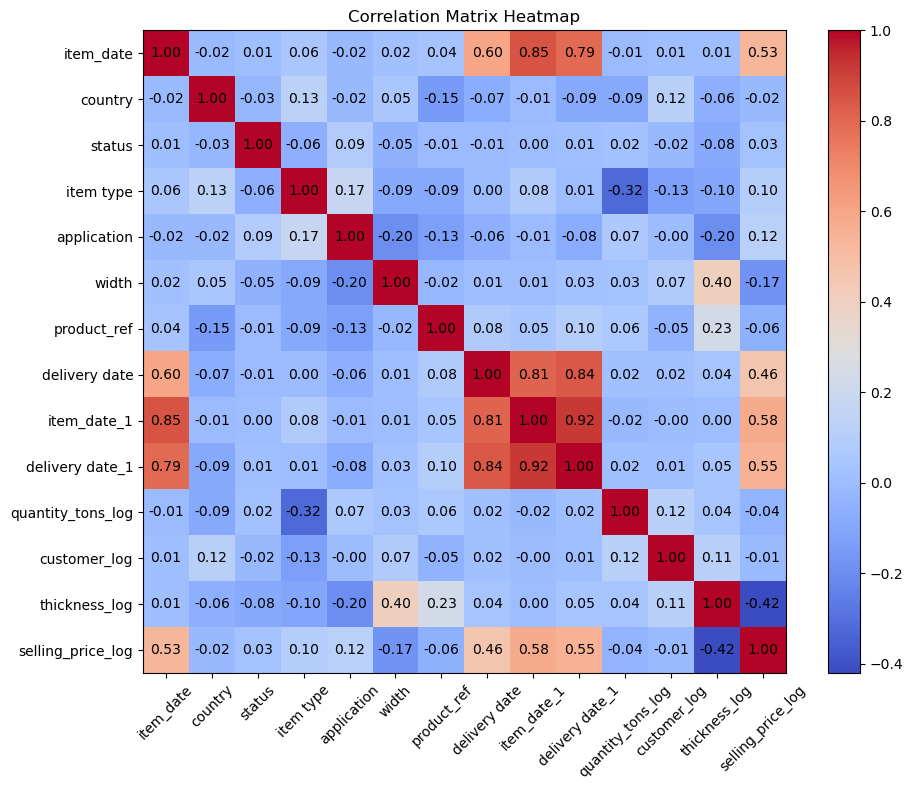

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = df3.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add annotations
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center', color='black')

# Set labels
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(np.arange(len(corr.columns)), corr.columns)

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [64]:
df4= df3.copy()

In [65]:
df4.head()

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log
0,20210401.0,28.0,1,5.0,10.0,1500.0,1670798778,20210701.0,2021-04-01,2021-07-01,3.991779,17.221905,0.693147,6.749931
1,20210401.0,25.0,1,5.0,41.0,1210.0,1668701718,20210401.0,2021-04-01,2021-04-01,6.643822,17.223450,-0.223144,6.953684
2,20210401.0,30.0,1,6.0,28.0,952.0,628377,20210101.0,2021-04-01,2021-01-01,5.956169,17.221827,-0.967584,6.468211
3,20210401.0,32.0,1,3.0,59.0,1317.0,1668701718,20210101.0,2021-04-01,2021-01-01,5.310301,17.228293,0.832909,6.643790
4,20210401.0,28.0,1,5.0,10.0,1980.0,640665,20210301.0,2021-04-01,2021-03-01,6.666354,17.223735,1.386294,6.357842


In [66]:
df4.dtypes

item_date                   float64
country                     float64
status                        int64
item type                   float64
application                 float64
width                       float64
product_ref                   int64
delivery date               float64
item_date_1          datetime64[ns]
delivery date_1      datetime64[ns]
quantity_tons_log           float64
customer_log                float64
thickness_log               float64
selling_price_log           float64
dtype: object

In [69]:
#converting the datatype (object to datetime format)
df4["delivery date_1"]= pd.to_datetime(df4["delivery date_1"])
df4["item_date_1"]= pd.to_datetime(df4["item_date_1"])

In [73]:
#identifying the difference of the "delivery date" and the "item date"
df4["date_differ"]= (df4["delivery date_1"]-df4["item_date_1"]).dt.days

In [74]:
df4["date_differ"]

0         91
1          0
2        -90
3        -90
4        -31
          ..
181668    -1
181669    -1
181670    -1
181671    -1
181672    -1
Name: date_differ, Length: 181667, dtype: int64

In [75]:
df4["item_date_day"]= df4["item_date_1"].dt.day
df4["item_date_month"]= df4["item_date_1"].dt.month
df4["item_date_year"]= df4["item_date_1"].dt.year

In [76]:
df4.head()

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log,date_differ,item_date_day,item_date_month,item_date_year
0,20210401.0,28.0,1,5.0,10.0,1500.0,1670798778,20210701.0,2021-04-01,2021-07-01,3.991779,17.221905,0.693147,6.749931,91,1,4,2021
1,20210401.0,25.0,1,5.0,41.0,1210.0,1668701718,20210401.0,2021-04-01,2021-04-01,6.643822,17.223450,-0.223144,6.953684,0,1,4,2021
2,20210401.0,30.0,1,6.0,28.0,952.0,628377,20210101.0,2021-04-01,2021-01-01,5.956169,17.221827,-0.967584,6.468211,-90,1,4,2021
3,20210401.0,32.0,1,3.0,59.0,1317.0,1668701718,20210101.0,2021-04-01,2021-01-01,5.310301,17.228293,0.832909,6.643790,-90,1,4,2021
4,20210401.0,28.0,1,5.0,10.0,1980.0,640665,20210301.0,2021-04-01,2021-03-01,6.666354,17.223735,1.386294,6.357842,-31,1,4,2021


In [77]:
#separating the posive values(pv) dataframe and negative values(nv) dataframe based on the "date_differ" column
df4_pv= df4[df4["date_differ"]>=0]
df4_pv.reset_index(drop= True, inplace= True)

In [78]:
df4_pv.tail()

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log,date_differ,item_date_day,item_date_month,item_date_year
165555,20200702.0,25.0,0,3.0,15.0,1980.0,640665,20200801.0,2020-07-02,2020-08-01,3.472467,17.224270,1.791759,6.313548,30,2,7,2020
165556,20200702.0,30.0,0,3.0,10.0,1525.0,640665,20200801.0,2020-07-02,2020-08-01,4.196171,17.222079,1.348073,6.126869,30,2,7,2020
165557,20200702.0,30.0,0,3.0,10.0,1525.0,640665,20200801.0,2020-07-02,2020-08-01,4.156686,17.222079,1.766442,6.124683,30,2,7,2020
165558,20200702.0,30.0,0,3.0,10.0,1500.0,640665,20200801.0,2020-07-02,2020-08-01,4.025862,17.222079,2.060514,6.126869,30,2,7,2020
165559,20200702.0,30.0,0,3.0,10.0,1830.0,640665,20200801.0,2020-07-02,2020-08-01,5.328963,17.222079,1.348073,6.131226,30,2,7,2020


In [79]:
df4_nv= df4[df4["date_differ"]<0]
df4_nv.reset_index(drop= True, inplace= True)

In [80]:
df4_nv.tail()

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log,date_differ,item_date_day,item_date_month,item_date_year
16102,20200702.0,25.0,1,5.0,41.0,1220.0,164141591,20200701.0,2020-07-02,2020-07-01,4.629691,17.223381,-0.040822,6.381816,-1,2,7,2020
16103,20200702.0,25.0,1,5.0,41.0,1500.0,164141591,20200701.0,2020-07-02,2020-07-01,5.337954,17.223381,-0.051293,6.378426,-1,2,7,2020
16104,20200702.0,25.0,1,5.0,41.0,1250.0,164141591,20200701.0,2020-07-02,2020-07-01,1.443523,17.223381,-0.342490,6.428105,-1,2,7,2020
16105,20200702.0,25.0,1,5.0,41.0,1250.0,164141591,20200701.0,2020-07-02,2020-07-01,6.925087,17.223381,-0.162519,6.398595,-1,2,7,2020
16106,20200702.0,25.0,1,5.0,41.0,1240.0,164141591,20200701.0,2020-07-02,2020-07-01,6.008043,17.223381,-0.342490,6.408529,-1,2,7,2020


In [81]:
# now we want to create the model for delivery date prediction
# importing the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [82]:
df4_pv.columns

Index(['item_date', 'country', 'status', 'item type', 'application', 'width',
       'product_ref', 'delivery date', 'item_date_1', 'delivery date_1',
       'quantity_tons_log', 'customer_log', 'thickness_log',
       'selling_price_log', 'date_differ', 'item_date_day', 'item_date_month',
       'item_date_year'],
      dtype='object')

In [86]:
#Find the best algorithm for the "delivery date" prediction

def accuracy_date_prediction(df, algorithm):
  x= df.drop(columns=["item_date_1", "delivery date_1", "date_differ"])
  y= df["date_differ"]

  #teain test splitting
  x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.2, random_state=42)

  model= algorithm().fit(x_train,y_train)
  y_pred= model.predict(x_test)

  #checking the accuracy score
  mse= mean_squared_error(y_test, y_pred)
  rmse= np.sqrt(mse)
  mae= mean_absolute_error(y_test,y_pred)
  r2= r2_score(y_test, y_pred)

  metrics={"R2_score":r2,
           "Mean_squared_error":mse,
           "Root_mean_squared_error":rmse,
           "Mean_absolute_error":mae,
           }
  return metrics


In [87]:
print(accuracy_date_prediction(df4_pv,DecisionTreeRegressor))
print(accuracy_date_prediction(df4_pv,RandomForestRegressor))
print(accuracy_date_prediction(df4_pv,ExtraTreesRegressor))
print(accuracy_date_prediction(df4_pv,GradientBoostingRegressor))
print(accuracy_date_prediction(df4_pv,AdaBoostRegressor))
print(accuracy_date_prediction(df4_pv,XGBRegressor))

{'R2_score': 0.9999475335688078, 'Mean_squared_error': 0.08108842715631795, 'Root_mean_squared_error': 0.28476029771777867, 'Mean_absolute_error': 0.005587098332930659}
{'R2_score': 0.9999808940080984, 'Mean_squared_error': 0.029528877748248385, 'Root_mean_squared_error': 0.17183968618525927, 'Mean_absolute_error': 0.006542039139888866}
{'R2_score': 0.9999857338399931, 'Mean_squared_error': 0.022048773858419923, 'Root_mean_squared_error': 0.14848829535832084, 'Mean_absolute_error': 0.012146653781106576}
{'R2_score': 0.9879986939823603, 'Mean_squared_error': 18.548374773723705, 'Root_mean_squared_error': 4.306782415414517, 'Mean_absolute_error': 3.1172418952300975}
{'R2_score': 0.7379644720514802, 'Mean_squared_error': 404.98368838157336, 'Root_mean_squared_error': 20.12420652799939, 'Mean_absolute_error': 16.557231487775443}
{'R2_score': 0.9999349215385416, 'Mean_squared_error': 0.1005806943889363, 'Root_mean_squared_error': 0.317144595396069, 'Mean_absolute_error': 0.17687271445631053

In [90]:
# Model for the RandomForest

def RandomForest(train_df, test_df):

  x= train_df.drop(columns=["item_date_1", "delivery date_1", "date_differ"])
  y= train_df["date_differ"]

  #train test splitting
  x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.2, random_state=42)
  model= RandomForestRegressor().fit(x_train, y_train)

  data= test_df.drop(columns=["item_date_1", "delivery date_1", "date_differ"])

  y_pred=model.predict(data)

  return y_pred


In [91]:
date_difference= RandomForest(df4_pv,df4_nv)

In [92]:
date_difference

array([17.  , 16.91,  0.  , ..., 30.  , 30.  , 30.  ])

In [93]:
# changing the "date_differ" datatype float into int
date_difference_1= []
for i in date_difference:
  dd= int(round(i,0))
  date_difference_1.append(dd)


In [94]:
df4_nv["date_differ"]= pd.DataFrame(date_difference_1)

In [95]:
df4_nv.isnull().sum()

item_date            0
country              0
status               0
item type            0
application          0
width                0
product_ref          0
delivery date        0
item_date_1          0
delivery date_1      0
quantity_tons_log    0
customer_log         0
thickness_log        0
selling_price_log    0
date_differ          0
item_date_day        0
item_date_month      0
item_date_year       0
dtype: int64

In [96]:
#find the delivery date using "item_date_1" and "date_differ"

def find_delivery_date(item_date, date_differ):
  date= item_date + pd.to_timedelta(date_differ,unit= "D")
  return date

In [97]:
df4_nv["delivery date_1"]= find_delivery_date(df4_nv["item_date_1"],df4_nv["date_differ"])

In [98]:
# Concadinating the two dataframes(df4_pv,df4_nv) based on the rows
df_final=pd.concat([df4_pv,df4_nv],axis=0,ignore_index=True)

In [99]:
df_final.tail()

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,quantity_tons_log,customer_log,thickness_log,selling_price_log,date_differ,item_date_day,item_date_month,item_date_year
181662,20200702.0,25.0,1,5.0,41.0,1220.0,164141591,20200701.0,2020-07-02,2020-08-01,4.629691,17.223381,-0.040822,6.381816,30,2,7,2020
181663,20200702.0,25.0,1,5.0,41.0,1500.0,164141591,20200701.0,2020-07-02,2020-08-01,5.337954,17.223381,-0.051293,6.378426,30,2,7,2020
181664,20200702.0,25.0,1,5.0,41.0,1250.0,164141591,20200701.0,2020-07-02,2020-08-01,1.443523,17.223381,-0.342490,6.428105,30,2,7,2020
181665,20200702.0,25.0,1,5.0,41.0,1250.0,164141591,20200701.0,2020-07-02,2020-08-01,6.925087,17.223381,-0.162519,6.398595,30,2,7,2020
181666,20200702.0,25.0,1,5.0,41.0,1240.0,164141591,20200701.0,2020-07-02,2020-08-01,6.008043,17.223381,-0.342490,6.408529,30,2,7,2020


In [100]:
# Now we create the three new columns using the "delivery_date_1"
df_final['delivery_date_day']= df_final["delivery date_1"].dt.day
df_final['delivery_date_month']= df_final["delivery date_1"].dt.month
df_final['delivery_date_year']= df_final["delivery date_1"].dt.year

In [101]:
df_final.head(2)

,item_date,country,status,item type,application,width,product_ref,delivery date,item_date_1,delivery date_1,...,customer_log,thickness_log,selling_price_log,date_differ,item_date_day,item_date_month,item_date_year,delivery_date_day,delivery_date_month,delivery_date_year
0,20210401.0,28.0,1,5.0,10.0,1500.0,1670798778,20210701.0,2021-04-01,2021-07-01,...,17.221905,0.693147,6.749931,91,1,4,2021,1,7,2021
1,20210401.0,25.0,1,5.0,41.0,1210.0,1668701718,20210401.0,2021-04-01,2021-04-01,...,17.223450,-0.223144,6.953684,0,1,4,2021,1,4,2021


In [102]:
df_final.columns

Index(['item_date', 'country', 'status', 'item type', 'application', 'width',
       'product_ref', 'delivery date', 'item_date_1', 'delivery date_1',
       'quantity_tons_log', 'customer_log', 'thickness_log',
       'selling_price_log', 'date_differ', 'item_date_day', 'item_date_month',
       'item_date_year', 'delivery_date_day', 'delivery_date_month',
       'delivery_date_year'],
      dtype='object')

In [103]:
# Droping the unwanted columns
df_final.drop(columns=["item_date","delivery date","item_date_1","delivery date_1","date_differ"],inplace=True)

In [104]:
df_final.columns

Index(['country', 'status', 'item type', 'application', 'width', 'product_ref',
       'quantity_tons_log', 'customer_log', 'thickness_log',
       'selling_price_log', 'item_date_day', 'item_date_month',
       'item_date_year', 'delivery_date_day', 'delivery_date_month',
       'delivery_date_year'],
      dtype='object')

In [105]:
df_final.to_csv("Industrial_Copper_Colab.csv",index= False)

In [106]:
df_final= pd.read_csv(r"C:\Users\Asus\Industrial_Copper_Colab.csv")

In [107]:
#packages
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,auc,roc_curve,confusion_matrix,classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.combine import SMOTETomek

import pickle

In [108]:
df_class= df_final.copy()

In [109]:
# filter the status column only want to be a (won& loss)
df_c= df_class[(df_class["status"] == 1) | (df_class["status"] == 0)]

In [110]:
df_c.tail()

,country,status,item type,application,width,product_ref,quantity_tons_log,customer_log,thickness_log,selling_price_log,item_date_day,item_date_month,item_date_year,delivery_date_day,delivery_date_month,delivery_date_year
181662,25.0,1,5.0,41.0,1220.0,164141591,4.629691,17.223381,-0.040822,6.381816,2,7,2020,1,8,2020
181663,25.0,1,5.0,41.0,1500.0,164141591,5.337954,17.223381,-0.051293,6.378426,2,7,2020,1,8,2020
181664,25.0,1,5.0,41.0,1250.0,164141591,1.443523,17.223381,-0.342490,6.428105,2,7,2020,1,8,2020
181665,25.0,1,5.0,41.0,1250.0,164141591,6.925087,17.223381,-0.162519,6.398595,2,7,2020,1,8,2020
181666,25.0,1,5.0,41.0,1240.0,164141591,6.008043,17.223381,-0.342490,6.408529,2,7,2020,1,8,2020


In [111]:
df_c["status"].value_counts()

status
1    116009
0     34436
Name: count, dtype: int64

In [112]:
df_c.columns

Index(['country', 'status', 'item type', 'application', 'width', 'product_ref',
       'quantity_tons_log', 'customer_log', 'thickness_log',
       'selling_price_log', 'item_date_day', 'item_date_month',
       'item_date_year', 'delivery_date_day', 'delivery_date_month',
       'delivery_date_year'],
      dtype='object')

In [113]:
x= df_c.drop(columns=["status"],axis=1)
y= df_c["status"]

In [114]:
x.shape,y.shape

((150445, 15), (150445,))

In [115]:
x_new,y_new= SMOTETomek().fit_resample(x,y)

In [116]:
x_new.shape,y_new.shape

((230118, 15), (230118,))

In [117]:
y_new.value_counts()

status
1    115059
0    115059
Name: count, dtype: int64

In [118]:
# find the best algorithm for the classification prediction

def accuracy_checking(x_data, y_data, algorithm):
  #train test splitting
  x_train, x_test, y_train, y_test= train_test_split(x_data, y_data, test_size= 0.2, random_state=42)

  model= algorithm().fit(x_train, y_train)

  y_pred_train= model.predict(x_train)
  y_pred_test= model.predict(x_test)

  #checking the accuracy_score
  accuracy_train= accuracy_score(y_train, y_pred_train)
  accuracy_test= accuracy_score(y_test, y_pred_test)

  metrics={"Algorithm": algorithm.__name__,
           "Accuracy_Train": accuracy_train,
           "Accuracy_Test": accuracy_test}
  return metrics


In [119]:
print(accuracy_checking(x,y,DecisionTreeClassifier))
print(accuracy_checking(x,y,RandomForestClassifier))
print(accuracy_checking(x,y,ExtraTreesClassifier))
print(accuracy_checking(x,y,AdaBoostClassifier))
print(accuracy_checking(x,y,GradientBoostingClassifier))
print(accuracy_checking(x,y,XGBClassifier))

{'Algorithm': 'DecisionTreeClassifier', 'Accuracy_Train': 1.0, 'Accuracy_Test': 0.9509122935291967}
{'Algorithm': 'RandomForestClassifier', 'Accuracy_Train': 0.9999916913157633, 'Accuracy_Test': 0.9689919904283958}
{'Algorithm': 'ExtraTreesClassifier', 'Accuracy_Train': 1.0, 'Accuracy_Test': 0.973844262022666}
{'Algorithm': 'AdaBoostClassifier', 'Accuracy_Train': 0.8142759812556084, 'Accuracy_Test': 0.8162783741566686}
{'Algorithm': 'GradientBoostingClassifier', 'Accuracy_Train': 0.8360613513244043, 'Accuracy_Test': 0.8371830236963674}
{'Algorithm': 'XGBClassifier', 'Accuracy_Train': 0.9462012695669514, 'Accuracy_Test': 0.9340290471600917}


In [120]:
print(accuracy_checking(x_new,y_new,DecisionTreeClassifier))
print(accuracy_checking(x_new,y_new,RandomForestClassifier))
print(accuracy_checking(x_new,y_new,ExtraTreesClassifier))
print(accuracy_checking(x_new,y_new,AdaBoostClassifier))
print(accuracy_checking(x_new,y_new,GradientBoostingClassifier))
print(accuracy_checking(x_new,y_new,XGBClassifier))

{'Algorithm': 'DecisionTreeClassifier', 'Accuracy_Train': 1.0, 'Accuracy_Test': 0.963758039283852}
{'Algorithm': 'RandomForestClassifier', 'Accuracy_Train': 1.0, 'Accuracy_Test': 0.9821180253780636}
{'Algorithm': 'ExtraTreesClassifier', 'Accuracy_Train': 1.0, 'Accuracy_Test': 0.985073005388493}
{'Algorithm': 'AdaBoostClassifier', 'Accuracy_Train': 0.7774071941508143, 'Accuracy_Test': 0.775942986268034}
{'Algorithm': 'GradientBoostingClassifier', 'Accuracy_Train': 0.8207002944148098, 'Accuracy_Test': 0.8173344342082391}
{'Algorithm': 'XGBClassifier', 'Accuracy_Train': 0.9532630069421056, 'Accuracy_Test': 0.9475056492264905}


In [125]:
x_train, x_test, y_train, y_test= train_test_split(x_new, y_new, test_size= 0.2, random_state= 42)

model= RandomForestClassifier(max_depth=20, max_features= None, min_samples_leaf=1, min_samples_split=2).fit(x_train,y_train)

y_pred_train= model.predict(x_train)
y_pred_test= model.predict(x_test)

#checking the accuracy_score for train and test

accuracy_train= accuracy_score(y_train, y_pred_train)
accuracy_test= accuracy_score(y_test, y_pred_test)

print("Accuracy score for Train and Test")
print("----------------------------------")
print("Accuracy_Train: ",accuracy_train)
print("Accuracy_Test: ",accuracy_test)
print("  ")
#confution matrics and the classification report for test

print("Confution_matrix for Test")
print("--------------------------")
print(confusion_matrix(y_true= y_test, y_pred= y_pred_test))
print(" ")
print("Classification_report for Test")
print("-------------------------------")
print(classification_report(y_true= y_test, y_pred= y_pred_test))

Accuracy score for Train and Test
----------------------------------
Accuracy_Train:  0.9850511151911523
Accuracy_Test:  0.9681253259169129
  
Confution_matrix for Test
--------------------------
[[22770   386]
 [ 1081 21787]]
 
Classification_report for Test
-------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     23156
           1       0.98      0.95      0.97     22868

    accuracy                           0.97     46024
   macro avg       0.97      0.97      0.97     46024
weighted avg       0.97      0.97      0.97     46024



In [126]:
# Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC)

FP,TP,threshold= roc_curve(y_true= y_test, y_score=y_pred_test)
print(threshold)
print(FP)
print(TP)
print(" ")
auc_curve= auc(x=FP,y=TP)
print("auc_curve:",auc_curve)

[2 1 0]
[0.         0.01666955 1.        ]
[0.        0.9527287 1.       ]
 
auc_curve: 0.9680295790877809


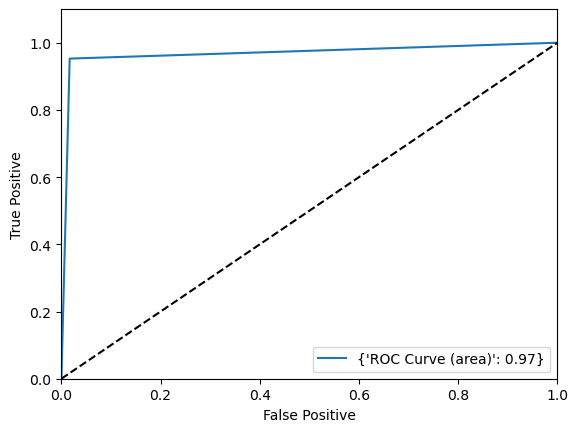

In [127]:
# create a plot for roc and auc curve
roc_point= {"ROC Curve (area)":round(auc_curve,2)}
plt.plot(FP,TP,label= roc_point)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.plot([0,1],[0,1],"k--")
plt.legend(loc= "lower right")
plt.show()

In [128]:
user_data = np.array([[30153963, 30, 6, 28, 952, 628377, 5.9, -0.96, 6.46, 1,4,2021,1,1,2021]])
y_pred_user= model.predict(user_data)
if y_pred_user == 1:
    print("Won")
else:
    print("Lose")

Won


In [129]:
#saving the model using the pickle

with open("Classification_model.pkl","wb") as f:
    pickle.dump(model,f)

In [131]:
with open(r"C:\Users\Asus\Classification_model.pkl","rb") as f1:
  class_model= pickle.load(f1)

In [132]:
user_data = np.array([[77.0,3.0,10.0,1500.0,164141591,3.677655,17.222226,0.000000,7.110696,1,4,2021,1,8,2021]])
y_pred_user= class_model.predict(user_data)

if y_pred_user == 1:
    print("Won")
else:
    print("Lose")

Lose


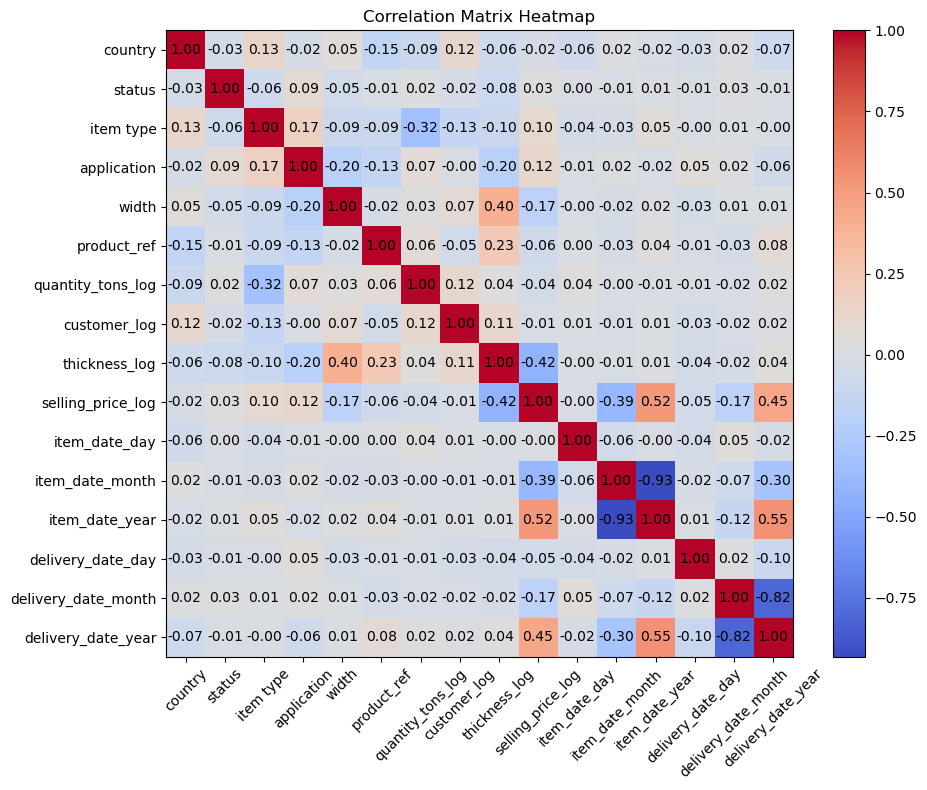

In [136]:
corr = df_final.corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add annotations
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j, i, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center', color='black')

# Set labels
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

#**Regression Method - Predict the Selling Price**

In [137]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [138]:
df_regg= df_final.copy()

In [139]:
def accuracy_regressor(df,algorithm):

  x= df.drop(columns=["selling_price_log"], axis=1)
  y= df["selling_price_log"]

  #train test splitting
  x_train,x_test, y_train, y_test= train_test_split(x,y, test_size= 0.2, random_state=42)
  model= algorithm().fit(x_train, y_train)

  y_pred_train= model.predict(x_train)
  y_pred_test= model.predict(x_test)

  r2_train= r2_score(y_train, y_pred_train)
  r2_test= r2_score(y_test, y_pred_test)

  metrics={"Algorithm":algorithm.__name__,
           "R2_Train": r2_train,
           "R2_Test": r2_test}

  return metrics

In [140]:
print(accuracy_regressor(df_regg, DecisionTreeRegressor))
print(accuracy_regressor(df_regg, RandomForestRegressor))
print(accuracy_regressor(df_regg, ExtraTreesRegressor))
print(accuracy_regressor(df_regg, AdaBoostRegressor))
print(accuracy_regressor(df_regg, GradientBoostingRegressor))
print(accuracy_regressor(df_regg, XGBRegressor))

{'Algorithm': 'DecisionTreeRegressor', 'R2_Train': 0.9998986269392148, 'R2_Test': 0.9249355987648651}
{'Algorithm': 'RandomForestRegressor', 'R2_Train': 0.9938784161699392, 'R2_Test': 0.9578081095118012}
{'Algorithm': 'ExtraTreesRegressor', 'R2_Train': 0.9998986269392148, 'R2_Test': 0.9548527353667621}
{'Algorithm': 'AdaBoostRegressor', 'R2_Train': 0.6685534155536774, 'R2_Test': 0.6644379380455413}
{'Algorithm': 'GradientBoostingRegressor', 'R2_Train': 0.8870138282490457, 'R2_Test': 0.8849458761560421}
{'Algorithm': 'XGBRegressor', 'R2_Train': 0.9515725523170755, 'R2_Test': 0.9460058617152528}


In [141]:
# pass the parameters and check the accuracy for both training and testing & overfitting

x = df_regg.drop(columns=['selling_price_log'], axis=1)
y = df_regg['selling_price_log']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

model_r = RandomForestRegressor(max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2).fit(x_train, y_train)
y_pred_train = model_r.predict(x_train)
y_pred_test = model_r.predict(x_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
r2_train, r2_test

(0.9865702260556612, 0.9568920210395744)

In [142]:
#predict the selling price with hypertuning parameters and calculate the accuracy using metrics

x = df_regg.drop(columns=['selling_price_log'], axis=1)
y = df_regg['selling_price_log']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

model_r = RandomForestRegressor(max_depth=20, max_features=None, min_samples_leaf=1, min_samples_split=2).fit(x_train, y_train)
y_pred = model_r.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

metrics_r = {'R2': r2,
           'Mean Absolute Error': mae,
           'Mean Squared Error': mse,
           'Root Mean Squared Error': rmse}

metrics_r

{'R2': 0.956634190536054,
 'Mean Absolute Error': 0.031998732987773074,
 'Mean Squared Error': 0.0028168185497205083,
 'Root Mean Squared Error': 0.05307370864863797}

In [143]:
user_data = np.array([[30202938,25,1,5,41,1210,1668701718,6.6,-0.2,1,4,2021,1,4,2021]])
y_pred = model_r.predict(user_data)
print("Predicted selling price with Log: ",y_pred[0])
print("Predicted selling price without Log: ",np.exp(y_pred[0]))

Predicted selling price with Log:  7.1417815149486845
Predicted selling price without Log:  1263.6776455773067


In [144]:
import pickle

In [145]:
with open("Regression_Model.pkl","wb") as r:
  pickle.dump(model_r,r)

In [146]:
with open("Regression_Model.pkl","rb") as r1:
  regg_model=pickle.load(r1)

In [147]:
df_final.head()


,country,status,item type,application,width,product_ref,quantity_tons_log,customer_log,thickness_log,selling_price_log,item_date_day,item_date_month,item_date_year,delivery_date_day,delivery_date_month,delivery_date_year
0,28.0,1,5.0,10.0,1500.0,1670798778,3.991779,17.221905,0.693147,6.749931,1,4,2021,1,7,2021
1,25.0,1,5.0,41.0,1210.0,1668701718,6.643822,17.223450,-0.223144,6.953684,1,4,2021,1,4,2021
2,25.0,1,5.0,41.0,1265.0,1668701718,5.419608,17.223450,0.405465,6.890609,1,4,2021,1,4,2021
3,30.0,2,5.0,41.0,1125.0,611993,1.259203,17.223667,-0.967584,5.975038,1,4,2021,1,7,2021
4,38.0,1,3.0,10.0,1275.0,1668701376,4.235147,17.228025,-0.510826,7.217443,1,4,2021,1,7,2021


In [148]:
user_data = np.array([[28.0,1,5.0,10.0,1500.0,1670798778,3.991779,17.221905,0.693147,1,4,2021,1,7,2021]])
y_pred = regg_model.predict(user_data)
print("Predicted selling price with Log: ",y_pred[0])
print("Predicted selling price without Log: ",np.exp(y_pred[0]))

Predicted selling price with Log:  6.863220470909654
Predicted selling price without Log:  956.4423076010312
